In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.regularizers import l1_l2
from keras.models import Model, clone_model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Concatenate, Activation, Subtract, merge, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras import metrics
from keras import losses
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm_notebook
from keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
from os import listdir
from os.path import isfile, join
trainPath = "../../dataset/shuffled-dataset/TrainingSet/"
valPath = "../../dataset/shuffled-dataset/ValidationSet/"
trainPairs = pd.read_csv("../../dataset/shuffled-dataset/dataset_seen_training_siamese.csv")
valPairs = pd.read_csv("../../dataset/shuffled-dataset/dataset_seen_validation_siamese.csv")

In [3]:
trainPairs.head()

,Unnamed: 0,left,right,label
0,0,0725a_num4.png,0725a_num5.png,1
1,1,0725a_num4.png,0725b_num3.png,1
2,2,0725a_num4.png,0725c_num1.png,1
3,3,0725a_num4.png,0725b_num1.png,1
4,4,0725a_num4.png,0725a_num1.png,1


In [4]:
def trainGen(batchSize,stickyPath,_data,vis=False):
    idx = 0
    hshift = (-64,64)
    vshift = (-64,64)
    while(True):
        rows = np.random.randint(0,len(_data),batchSize)
        data = _data.loc[rows]
        returnInput=[]
        labelReturn = []
        for row in data.iterrows():
            skeleton = []
            left = cv2.imread(str(stickyPath+str(row[1][1])),cv2.IMREAD_GRAYSCALE)
            right = cv2.imread(str(stickyPath+str(row[1][2])),cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            rightImage = right.astype('float32')
            rightImage /= 255
            rightImage = 1 - rightImage
            
            temp=[leftImage,rightImage]
            
            skeleton.append(temp)
            labelReturn.append(row[1][3])
            
            # Shifting
            randH = np.random.randint(hshift[0],hshift[1])
            randV = np.random.randint(vshift[0],vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)
            
            temp = [leftImageShiftedV,rightImageShiftedH]
            skeleton.append(temp)
            labelReturn.append(row[1][3])
            
            temp = [leftImageShiftedH,rightImageShiftedV]
            skeleton.append(temp)
            labelReturn.append(row[1][3])
            
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(2,batchSize*3,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,4)
        
        labelReturn = np.array(labelReturn)
        labelReturn = labelReturn.reshape(batchSize*3,1)
        
        yield [returnInput[0,:,:,:],returnInput[1,:,:,:]],np.array(labelReturn)

def valGen(batchSize,stickyPath,_data,vis=False,rand=True):
    idx = 0
    while(True):
        if(rand):
            rows = np.random.randint(0,len(_data),len(_data))
            data = _data.loc[rows]
        else:
            data = _data
        returnInput=[]
        labelReturn = []
        for row in data.iterrows():
            skeleton = []
            left = cv2.imread(str(stickyPath+str(row[1][1])),cv2.IMREAD_GRAYSCALE)
            right = cv2.imread(str(stickyPath+str(row[1][2])),cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = left.astype('float32')
            leftImage /= 255
            leftImage = 1 - leftImage
            rightImage = right.astype('float32')
            rightImage /= 255
            rightImage = 1 - rightImage
            
            temp=[leftImage,rightImage]
            
            skeleton.append(temp)
            labelReturn.append(row[1][3])
            
            returnInput.append(skeleton)     
        returnInput = np.array(returnInput)
        returnInput = returnInput.reshape(2,len(_data)*1,64,64)
        
        blank =[]
        
        blank.append(returnInput)
        
        returnInput = np.array(blank)
        
        returnInput = np.moveaxis(returnInput,0,4)
        
        labelReturn = np.array(labelReturn)
        labelReturn = labelReturn.reshape(len(_data)*1,1)
        
        yield [returnInput[0,:,:,:],returnInput[1,:,:,:]],np.array(labelReturn)


In [5]:
def baseAE():
    input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten()(x)
    encoded = Dense(8*8*8, activation='relu', name='latent')(encoded)
    # model = Model(input_img,encoded)
    # print(model.summary())
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    r = Reshape(target_shape=(8,8,8))(encoded)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(r)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    #x = BatchNormalization()(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)
    return Model(input_img, decoded)

#display(SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))


In [6]:
ae_left = baseAE()
ae_right = baseAE()

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
ae_left.load_weights("../weights/simple_ae_maxpool_shuffled_weights_v1.h5")
ae_right.load_weights("../weights/simple_ae_maxpool_shuffled_weights_v1.h5")

In [8]:
for layer in ae_left.layers:
    layer.trainable = False
for layer in ae_right.layers:
    layer.trainable = False

In [9]:
for layer in ae_right.layers:
    layer.name = layer.name + str("r_r")

In [10]:
layer = Concatenate()([ae_left.get_layer('latent').output,ae_right.get_layer('latentr_r').output])

In [11]:
writerVerification = Model([ae_left.input,ae_right.input], layer)

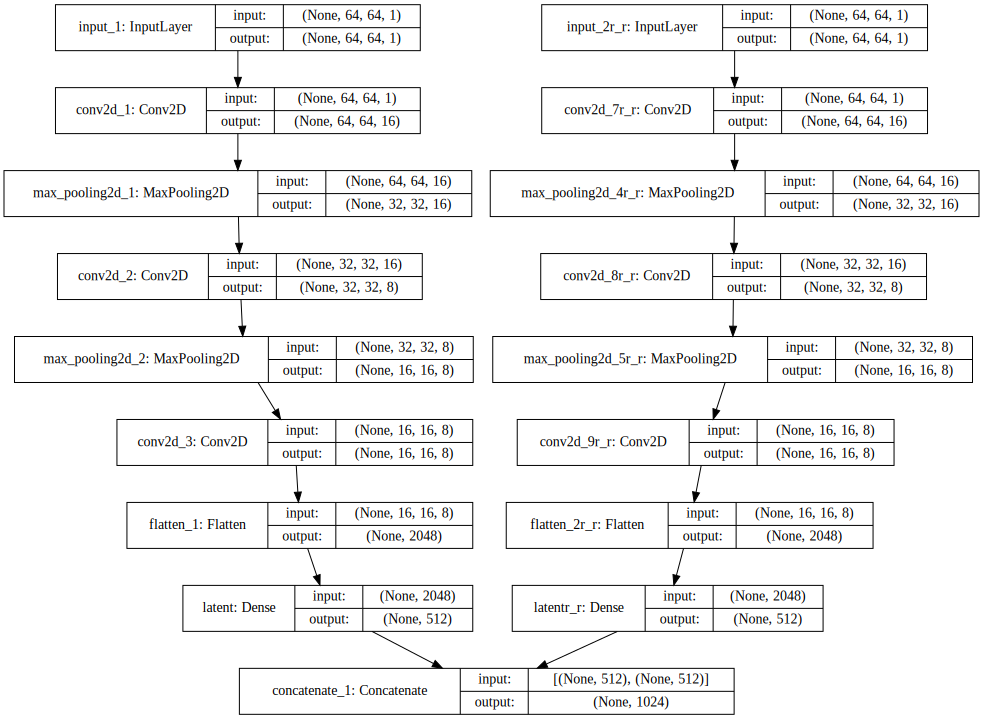

In [12]:
display(SVG(model_to_dot(writerVerification, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

In [13]:
batchSize=25
trainGenObj = trainGen(batchSize,trainPath,trainPairs)
valGenObj = valGen(batchSize,valPath,valPairs,rand=False)

In [14]:
pred  = writerVerification.predict_generator(valGenObj,steps=1)

In [63]:
pred_sim = []
for idx in range(len(valPairs)):
    cosineDist = float(cosine_similarity([pred[idx][0:512]],[pred[idx][512:]]))
    if(cosineDist > 0.95):
        pred_sim.append(1)
    else:
        pred_sim.append(0)

In [64]:
precision_recall_fscore_support(valPairs.label.tolist(), pred_sim, average='binary')

(0.5054054054054054, 0.41280353200883, 0.4544349939246658, None)

In [65]:
acc = 0
for idx in range(len(valPairs)):
    if pred_sim[idx] == valPairs.label[idx]:
        acc +=1

In [66]:
acc/len(valPairs)

0.5044150110375276